/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<Figure size 432x288 with 0 Axes>

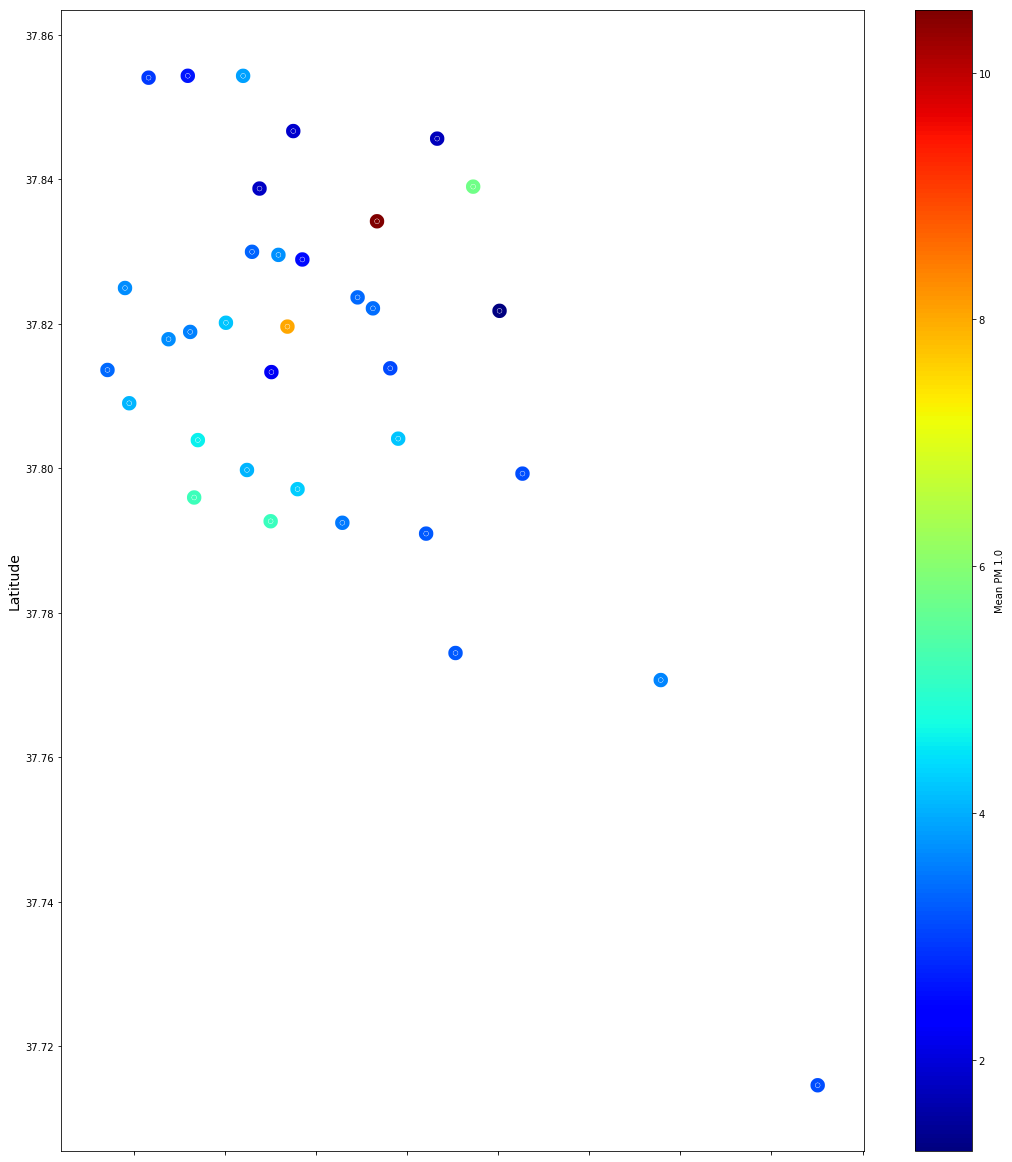

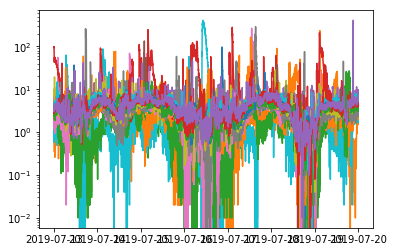

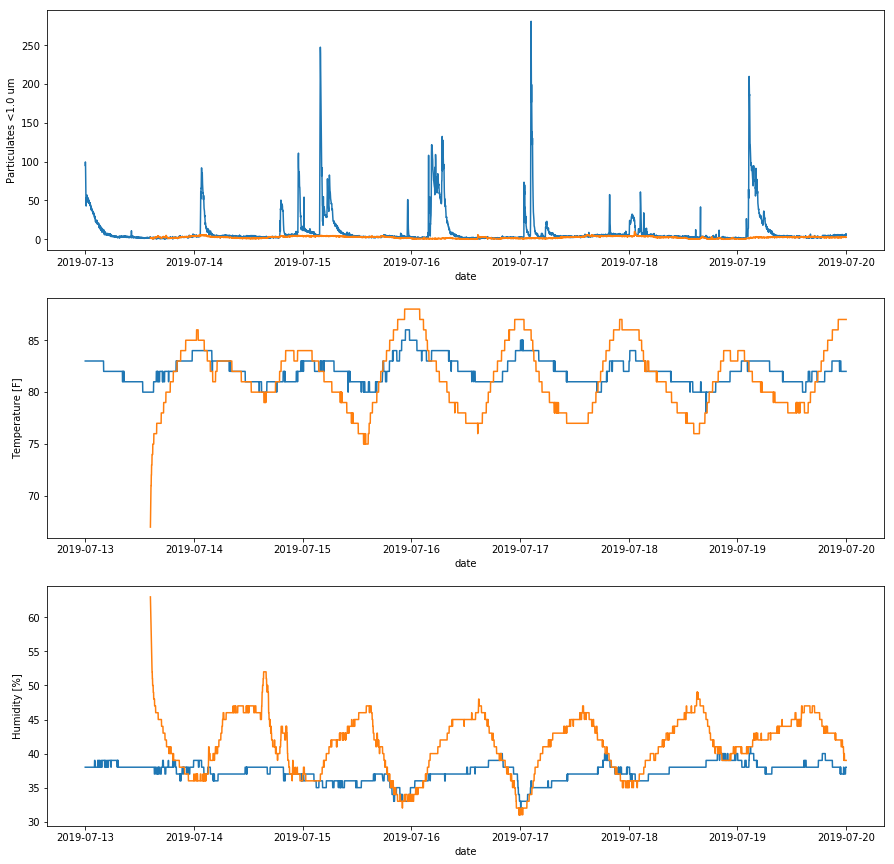

In [1]:
import json
import urllib
import requests
import gmaps as gmaps
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import medfilt
from pprint import pprint
from gmplot import gmplot
import glob
import os
plt.set_cmap('jet')
gmaps.configure(api_key='xxxxx')

##

#import air quality data

path = "/Users/katherinecochrane/Documents/datainc/capstone/purple_air/july2019"

all_sensor_data = glob.glob(os.path.join(path, "*.csv")) #make list of paths
my_dict={}
all_sensor_names=()
all_sensor_latitudes=()
all_sensor_longitudes=()

for file in all_sensor_data:
    sensor_name_temp=os.path.splitext(os.path.basename(file))[0]
    sensor_name=sensor_name_temp.split(' (')[0]
    sensor_coords=sensor_name_temp.split(' (')[1]
    sensor_latitude=sensor_coords.split( )[1][0:-1]
    sensor_longitude=sensor_coords.split(' ')[0]
    
    all_sensor_names=np.append(all_sensor_names,sensor_name)
    all_sensor_latitudes=np.append(all_sensor_latitudes,sensor_latitude)
    all_sensor_longitudes=np.append(all_sensor_longitudes,sensor_longitude)   
    my_dict[sensor_name] = pd.read_csv(file)
    
all_sensor_latitudes = [float(i) for i in all_sensor_latitudes]
all_sensor_longitudes = [float(i) for i in all_sensor_longitudes]

##

#### import tree data #####
trees_along_sidewalks_df=pd.read_csv('TreesAlongSidewalks.csv')
temp_lat=[]
temp_long=[]
for j in range(len(trees_along_sidewalks_df)):
    
    temp=trees_along_sidewalks_df['the_geom'][j]
    temp=temp.split(' ')
    temp_lat=np.append(temp_lat,float(temp[1][1:]))
    temp_long=np.append(temp_long,float(temp[2][:-1]))
    
trees_along_sidewalks_df['LATITUDE']=temp_long  
trees_along_sidewalks_df['LONGITUDE']=temp_lat

trees_append_df=trees_along_sidewalks_df[['OBJECTID','COLLDATE','LATITUDE','LONGITUDE']]

### taking mean of sensor data

mean_sensors_1pm=()
mean_sensors_2_5pm=()
mean_sensors_10pm=()
mean_sensors_temp=()
for name in all_sensor_names:
    my_dict[name]['TIMESTAMP']=pd.to_datetime(my_dict[name]['created_at'])
    if 'PM1.0_CF_ATM_ug/m3' in my_dict[name]:
        mean_sensors_1pm=np.append(mean_sensors_1pm,my_dict[name]['PM1.0_CF_ATM_ug/m3'].mean())
    if 'PM1.0_CF_1_ug/m3' in my_dict[name]:
        mean_sensors_1pm=np.append(mean_sensors_1pm,my_dict[name]['PM1.0_CF_1_ug/m3'].mean())
    if 'PM2.5_CF_ATM_ug/m3' in my_dict[name]:
        mean_sensors_10pm=np.append(mean_sensors_2_5pm,my_dict[name]['PM2.5_CF_ATM_ug/m3'].mean())
    if 'PM2.5_CF_1_ug/m3' in my_dict[name]:
        mean_sensors_10pm=np.append(mean_sensors_2_5pm,my_dict[name]['PM2.5_CF_1_ug/m3'].mean())
    if 'PM10.0_CF_ATM_ug/m3' in my_dict[name]:
        mean_sensors_10pm=np.append(mean_sensors_10pm,my_dict[name]['PM10.0_CF_ATM_ug/m3'].mean())
    if 'PM10.0_CF_1_ug/m3' in my_dict[name]:
        mean_sensors_10pm=np.append(mean_sensors_10pm,my_dict[name]['PM10.0_CF_1_ug/m3'].mean())
    if 'Temperature_F' in my_dict[name]:
        mean_sensors_temp=np.append(mean_sensors_10pm,my_dict[name]['Temperature_F'].mean())

###

sensor_information={'Name':all_sensor_names, 
                    'Latitude':all_sensor_longitudes,
                    'Longitude': all_sensor_latitudes, 
                    'Mean PM 1.0' :mean_sensors_1pm,
                    #'Mean PM 2.5' :mean_sensors_2_5pm,
                    #'Mean PM 10.0' :mean_sensors_10pm
                   }
sensor_information_df=pd.DataFrame(sensor_information)


### plotting of sensors and trees with matplotlib

#ax=trees_append_df.plot.scatter(y="LATITUDE", x="LONGITUDE",figsize=(7.6,11),
#                       colorbar=False, alpha=0.05, color='green')
#oakland_im=mpimg.imread('oakland_with_air monitors.png')

#sensor_information_df.plot.scatter(ax=ax,y="Latitude", x="Longitude",figsize=(7.6,11),
#                       colorbar=False, alpha=1, color='blue')
#x=plt.imshow(oakland_im, alpha=0.8)
sensor_information_df.plot.scatter(y='Latitude',x='Longitude',c='Mean PM 1.0',cmap='jet',linewidth=10,figsize=(18,21))
#sensor_information_df.plot.scatter(ax=ax,y='Latitude',x='Longitude',figsize=(15.2,22))

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
#plt.xlim(-122.32,-122.1)
#plt.ylim(37.72,37.872)
plt.savefig('sensors.pdf')
plt.show()

### google plotting sensor (and tree) data


fig=gmaps.figure(center=[37.78044, -122.2712], zoom_level= 12)
fig = gmaps.figure()

heatmap_sensor_layer=gmaps.heatmap_layer(
    sensor_information_df[['Latitude','Longitude']],
    sensor_information_df['Mean PM 1.0'],
    max_intensity=7, point_radius=20)                              
#sensor_layer = gmaps.symbol_layer(
#   sensor_information_df[['Latitude','Longitude']], fill_color='blue', stroke_color='blue', scale=2)

#trees_layer = gmaps.symbol_layer(
 #  trees_append_df.iloc[35000:37000][['LATITUDE','LONGITUDE']], fill_color='green', stroke_color='green', scale=1)
#fig.add_layer(trees_layer)
fig.add_layer(heatmap_sensor_layer)
fig

### examining all sensor data by time

leg=[]
ax = plt.gca()
for name in all_sensor_names:
    #my_dict[name].plot(x='TIMESTAMP',y='PM1.0_CF_ATM_ug/m3', ax=ax, figsize=(10,6))
    plt.semilogy(my_dict[name]['TIMESTAMP'],my_dict[name]['PM1.0_CF_ATM_ug/m3'])

    #leg.append(name)
#plt.legend(leg,loc='best')
plt.show()

### plotting two sensors that are close but show different behaviour

high_sensor_df=my_dict['Hilltop']
low_sensor_df=my_dict['Parkside Drive, Piedmont CA']

fig=plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.plot(high_sensor_df['TIMESTAMP'],high_sensor_df['PM1.0_CF_ATM_ug/m3'])
plt.plot(low_sensor_df['TIMESTAMP'],low_sensor_df['PM1.0_CF_ATM_ug/m3'])
plt.xlabel('date')
plt.ylabel('Particulates <1.0 um')
plt.subplot(3,1,2)
plt.plot(high_sensor_df['TIMESTAMP'],high_sensor_df['Temperature_F'])
plt.plot(low_sensor_df['TIMESTAMP'],low_sensor_df['Temperature_F'])
plt.xlabel('date')
plt.ylabel('Temperature [F]')
plt.subplot(3,1,3)
plt.plot(high_sensor_df['TIMESTAMP'],high_sensor_df['Humidity_%'])
plt.plot(low_sensor_df['TIMESTAMP'],low_sensor_df['Humidity_%'])
plt.xlabel('date')
plt.ylabel('Humidity [%]')
plt.savefig('two_sensors_data.pdf')
plt.show()





